# Scraping Masterarbeit --- Twitter (Versuch 1)

Eine erste Datei, um mittels der Daten von [J. Schmidt et al. (2021)](https://github.com/Leibniz-HBI/DBoeS-data-BTW21) die Twitter-Accounts der Kandidierenden zur BTW 2021 zu scrapen.

In [1]:
# basis packages
import requests
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
from pprint import pprint
import math
import json

# scrape packages: snscrape
import snscrape.modules.twitter as sntwitter
import itertools

## Datensatz: Infos zu allen Kandidierenden

+ Idee: Spalte TW_user ansprechen und dann scrape-Funktion erstellen, die die komplette Datenbank durchläuft für alle, bei denen TW_user nicht 'null' ist
    + [ ] erfordert evtl.: expression, um dem TW_user-Twitternamen ein "@" vorzulagern, da von snscrape benötigt
    + [X] braucht evtl. außerdem preprocessing-Schritt, dass alle 'null'-Werte entfernt werden
+ andere Möglichkeit: manuell die Namen kopieren und eintragen

In [4]:
# datensatz als pd dataframe laden
btw21_data = pd.read_csv("../DBoeS-data-BTW21/data.csv")

# vorbereitung: entferne alle kandidierenden OHNE twitteraccount aus datenbank
btw21_rem = btw21_data[btw21_data.TW_acc != 0]

# vorbereitung 2: behalte nur die kandidierenden im datensatz, die am ende auch erfolgreich mit kandidatur waren
btw21_rem = btw21_rem[btw21_rem.MdB_2021 != 0]

# preprocessing-version sichern
btw21_rem.to_csv("btw21_rem.csv")

# rest anzeigen --- 607 leute
btw21_rem

,ID,LAND_NR,Partei_NR,Partei_ABK,Name,Titel,Vorname,Nachname,Jahrgang,Geschlecht,...,erneut,TW_acc,TW_user,TW_id,TW_verif,FB_acc,FB_user,FB_id,FB_typ,FB_verif
0,1,5,2,SPD,"Abdi, Sanae",NaN,Sanae,Abdi,1986,1,...,0,1,_sanaeabdi,200695422,1,1,sanaeabdispd,111576226993790,1,1
1,2,8,4,FDP,"Abel, Valentin Christian",NaN,Valentin Christian,Abel,1991,2,...,0,1,Valentin_C_Abel,1699863337,1,1,valentinabel.fdp,1586699104972808,1,1
19,20,6,4,FDP,"Adler, Katja",NaN,Katja,Adler,1974,1,...,0,1,katjadler,712941191,2,1,katjadler,106967991184300,1,1
24,25,8,6,GRÜNE,"Aeffner, Stephanie",NaN,Stephanie,Aeffner,1976,1,...,0,1,s_aeffner,982288614,2,1,stephanie.aeffner,666817845,3,2
42,43,8,5,DIE LINKE,"Akbulut, Gökay",NaN,Gökay,Akbulut,1982,1,...,1,1,AkbulutGokay,800457587510476800,1,1,goekay.akbulut,1628676764050562,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,6166,5,1,CDU,"Ziemiak, Paul",NaN,Paul,Ziemiak,1985,2,...,1,1,PaulZiemiak,288696645,1,1,paulziemiak,100044268707373,1,1
6167,6168,12,2,SPD,"Zierke, Stefan",NaN,Stefan,Zierke,1970,2,...,1,1,zierke,64220313,1,1,ZierkeSPD,234636206679771,1,1
6174,6175,6,2,SPD,"Zimmermann, Dr. Jens",Dr.,Jens,Zimmermann,1981,2,...,1,1,JensZSPD,449619355,1,1,JensZSPD,315208841871484,1,1
6188,6189,8,1,CDU,"Zippelius, Nicolas Benjamin",NaN,Nicolas Benjamin,Zippelius,1987,2,...,0,1,NZippelius,1560104953,2,1,NZippelius,102135698530662,1,1


# Test der Scraping-Funktion

Die folgenden zwei Codezellen zeigen erste Anwendungsbeispiele, wie die snscrape-Funktion für Twitter verwendet werden könnte.

## Mögliche Argumente bzw. Attribute für Tweets

Für die Funktion `TwitterSearchScraper`; Infos hierzu gezogen vom [Blogeintrag von Martin Beck](https://betterprogramming.pub/how-to-scrape-tweets-with-snscrape-90124ed006af).

| **Attribut** | **Beschreibung** |
|:--------------|:------------------|
| *url* | URL des Tweets |
| *date* | Zeitstempel des Tweets |
| *content* (inzw. *rawContent*) | Inhalt des Tweets |
| *renderedContent* | vgl. *rawContent*, müsste aber Emojis beinhalten |
| *id* | Tweet-ID |
| *user* | userspezifische Abfragen, u. a.: username, displayname, id, description, descriptionUrls, verified, created, followersCount, friendsCount, statusesCount, favouritesCount, listedCount, mediaCount, location, protected, linkUrl, profileImageUrl, profileBannerUrl |
| *outlinks* | --- |
| *tcooutlinks* | --- |
| *replyCount* | Anzahl Antworten auf den Tweet |
| *retweetCount* | Anzahl Retweets des Tweets |
| *likeCount* | Anzahl Likes/Herzen des Tweets |
| *quoteCount* | Anzahl der Quotes des Tweets bzw. wie viele darauf geantwortet haben |
| *conversationId* | ID der gesamten Konversation (dürfte eigl. nur bei Retweets oder sowas interessant sein |
| *lang* | eine KI schätzt ab, in welcher Sprache der Tweet verfasst ist |
| *source* | von welchem Gerät der Tweet abgesetzt wurde (Computer, Smartphone, etc.) |
| *media* | Medienobjekt (Bild oder dergleichen), das an den Tweet angehängt wurde; hat eigene Unterattribute: previewUrl, fullUrl, type |
| *retweetedTweet* | wenn es ein Retweet ist, dann hier die ID des Originals |
| *quotedTweet* | wenn es ein zitierter Tweet ist, dann hier die ID des Originals |
| *mentionedUsers* | "User Objects" von Usern, die in dem Tweet direkt genannt werden |

In [19]:
# liste für tweets anlegen --- später in pd.DataFrame konvertieren
tweet_list_date = []

# scraping (mit datum: beispielsweise hier vom 01-01-2022 bis 24-11-2022)
for i, tweet in enumerate(sntwitter.TwitterSearchScraper('from:andreasscheuer since:2020-01-01 until:2022-11-24').get_items()):
    
    # auswahl der features, die gescraped werden sollen
    tweet_list_date.append([tweet.date, tweet.id, tweet.rawContent, tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.retweetedTweet, tweet.user.username])
    
# liste in pandas DataFrame umwandeln (einfachere Nutzung; bei Bedarf als CSV speicherbar)
tweets_bsp_date = pd.DataFrame(tweet_list_date, columns=['dateTime', 'tweetID', 'content', 'likes', 'replies', 'retweets', 'retweeted_yesno', 'username'])
tweets_bsp_date

KeyboardInterrupt: 

In [12]:
# liste für tweets anlegen --- später in pd.DataFrame konvertieren
tweet_list_all = []

# scraping aller tweets eines politikers
for i, tweet in enumerate(sntwitter.TwitterSearchScraper('from:andreasscheuer').get_items()):
    
    ## 1000000 tweets sind so viele, keiner der politiker sollte mehr abgesetzt haben
    if i > 1000000:
        break
    
    ## auswahl der features, die gescraped werden sollen
    tweet_list_all.append([tweet.date, tweet.id, tweet.rawContent, tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.retweetedTweet, tweet.user.username, tweet.user.id])
    
# liste in pandas DataFrame umwandeln (einfachere Nutzung; bei Bedarf als CSV speicherbar)
tweets_bsp_all = pd.DataFrame(tweet_list_all, columns=['dateTime', 'tweetID', 'content', 'likes', 'replies', 'retweets', 'retweeted_yesno', 'username'])
tweets_bsp_all

KeyboardInterrupt: 

# Versuch des Scrapens von Tweets für "Twitter-Deutschland"

Hier einige erste Ideen für das Scraping der Tweets von "Twitter-Deutschland". Es empfiehlt sich die Konsultation der Liste von [igorbrigadir auf GitHub](https://github.com/igorbrigadir/twitter-advanced-search) und die der [Twitter-API](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/geo#place) zum Thema.

1. Versuch nur mit `lang:de` => guter Versuch, aber a) extrem viele Tweets (mehr als 10 pro Sekunde möglich) und b) Deutsch sprechen nicht nur Menschen in Deutschland...

2. Versuch nur mit `country:Germany` => nur wenige Menschen auf Twitter haben das angegeben, nur wenige Tweets sind mit einer Geolocation verlinkt, verzerrt das Bild sehr stark
    
3. Versuch der Kombination von 1. und 2., also mit `lang:de` und `country:Germany` => wie viel Verlust kaufe ich mir, wenn ich **wirklich nur** die bestätigten Tweets mit Geotag aus Deutschland UND in deutscher Sprache hole? (extrem wenige Tweets, nur 217, überwiegend Firmen, so scheint es)

4. Versuch, `lang:de` in Kombination mit dem Geoparameter für Niederdorla (geogr. Mittelpunkt Deutschlands) + Radius 450 km (größte Ausdehnung Deutschlands, Nord-Süd-Achse) zu kombinieren. Damit erhält man alle *deutschsprachigen* Tweets, welche auch halbwegs gesichert *aus Deutschland* gesendet wurden => **bisher am vielversprechendsten!**

## Umsetzung von Idee 4

Idee 4 basiert auf der Annahme, dass der Mittelpunkt Deutschlands als Ausgangspunkt für ein Geolocation-basiertes Scraping genutzt werden könnte. Dazu wurde recherchiert: die größte Ausdehnung in Deutschland (komplett Nord bis komplett Süd) beträgt [876 km](https://alexaanswers.amazon.de/question/3rtkde0DvAhW3CitfWcV0z). Wenn man auf 900 km aufrundet und dies halbiert, kann der Wert als Orientierungsradius für snscrape verwendet werden.

Die Idee ist, den Mittelpunkt als Start zu nehmen und snscrape in einem Radius von 450 km um diesen herum alle Tweets scrapen zu lassen, die *auf Deutsch* verfasst wurden. So kann man evtl. noch mit eingeschlossene Belgier, Franzosen, Polen, Tschechen, Dänen oder frankophone bzw. Italo-Schweizer ausschließen. Einzig ein verschwindend geringer Anteil an österreichischen bzw. deutschsprachig-schweizerischen Usern könnte hypothetisch bestehen bleiben.

Durch die Abfrage von `user.location` in der Funktion am Ende wird geprüft, ob:

+ A) ein User einen Tweet mit Geotag abgesetzt hat: dann steht hier die Location des abgesetzten Tweets
+ B) ein User in seinem Profil eine `location` angegeben hat: dann wird diese hier gelistet

**Achtung: da die Dokumentation zum Python-Modul von [`snscrape`](https://github.com/JustAnotherArchivist/snscrape) leider etwas dürftig ist (Hauptaugenmerk des Entwicklers JustAnotherArchivist scheint eher auf dem CLI-Tool zu liegen), wurden die zuvor schon bekannten Infos um diejenigen aus [einem Artikel des Data Scientists Scott Tomlins](https://medium.com/swlh/how-to-scrape-tweets-by-location-in-python-using-snscrape-8c870fa6ec25) ergänzt.**

In [57]:
######## => Herangehensweise nach Tomlinson; Daten untidy

#loc = '51.09380, 10.26330, 450km' ## Niederdorla, Thüringen, geogr. Mittelpunkt Deutschlands
#df_coord = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
#    'lang:de geocode:"{}"'.format(loc)).get_items(), 5))[['user', 'date','rawContent', '']]


#df_coord['user_location'] =  df_coord['user'].apply(lambda x: x['location'])
#df_coord

In [53]:
##### gehört zu obiger zelle
# df_coord.user[0]

{'username': 'missjuliethotel',
 'id': 773479052195823617,
 'displayname': 'Judith Henke 🇺🇦',
 'rawDescription': 'Freie Journalistin @welt @investigativ_de @3x3Journalisten | Finanz- und Verbraucherthemen | 🎓 @KJS_Koeln und @WiSoUniCologne',
 'renderedDescription': 'Freie Journalistin @welt @investigativ_de @3x3Journalisten | Finanz- und Verbraucherthemen | 🎓 @KJS_Koeln und @WiSoUniCologne',
 'descriptionLinks': None,
 'verified': False,
 'created': datetime.datetime(2016, 9, 7, 11, 12, 31, tzinfo=datetime.timezone.utc),
 'followersCount': 4737,
 'friendsCount': 1505,
 'statusesCount': 4290,
 'favouritesCount': 22102,
 'listedCount': 12,
 'mediaCount': 356,
 'location': 'Deutschland',
 'protected': False,
 'link': {'text': 'welt.de/autor/judith-h…',
  'url': 'https://www.welt.de/autor/judith-henke/',
  'tcourl': 'https://t.co/MIoD0Y3vVy',
  'indices': (0, 23)},
 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1524068850563784707/wJzgngcG_normal.jpg',
 'profileBannerUrl': 'http

In [64]:
geolocator = '51.09380, 10.26330, 450km' ## Niederdorla, Thüringen, geogr. Mittelpunkt Deutschlands

# liste für tweets anlegen --- später in pd.DataFrame konvertieren
tweet_list_geo = []

# scraping (mit datum: beispielsweise hier vom 01-01-2022 bis 24-11-2022)
for i, tweet in enumerate(sntwitter.TwitterSearchScraper('lang:de geocode:"{}"'.format(geolocator))
                          .get_items()):
    
    ## limit for testing
    if i > 10:
        break
    
    # auswahl der features, die gescraped werden sollen
    tweet_list_geo.append([tweet.date, tweet.id, tweet.rawContent,
                           tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.retweetedTweet,
                           tweet.user.username, tweet.user.id, tweet.user.location])
    
# liste in pandas DataFrame umwandeln (einfachere Nutzung; bei Bedarf als CSV speicherbar)
geo_full = pd.DataFrame(tweet_list_geo, columns=['dateTime', 'tweetID', 'content',
                                                 'likes', 'replies', 'retweets',
                                                 'retweeted_yesno', 'username', 'userID', 'userLocation'])

geo_full

,dateTime,tweetID,content,likes,replies,retweets,retweeted_yesno,username,userID,userLocation
0,2022-11-25 13:30:23+00:00,1596134205146435596,Irgendwelche bres 17 Uhr challs knacken ?,0,0,0,None,Crizofy,701484506851762176,"Düsseldorf, Deutschland"
1,2022-11-25 13:30:23+00:00,1596134203158335489,@patriot_singles Das einzige was den interessi...,0,0,0,None,Corky08751620,1518439247753134080,"Regensburg, Deutschland"
2,2022-11-25 13:30:23+00:00,1596134202684354561,@CarryFeet @LadyRoxana11 die 🐷 fängt wohl bess...,0,0,0,None,smaragd2,232242704,"Baden-Württemberg, Deutschland"
3,2022-11-25 13:30:23+00:00,1596134201967149058,@letztegenAT vor Terroristen wie euch,0,0,0,None,F5568665995,1554364638682386433,Deutschland
4,2022-11-25 13:30:22+00:00,1596134201111502848,@NickFortnite10 @HeyStani Kuck eif bei letztem...,0,0,0,None,Tie57304811,1361602696319553536,Deutschland
5,2022-11-25 13:30:22+00:00,1596134200050081794,@FrankBuschmann Genau so ist es Buschi. Dieses...,0,0,0,None,dynmbln25,4060538061,"Berlin, Deutschland"
6,2022-11-25 13:30:22+00:00,1596134197923454976,@macheprobleme ich heule fr,0,0,0,None,PassMalDieKippe,1162719255143616514,"Cologne, Germany"
7,2022-11-25 13:30:22+00:00,1596134197848166406,@DurhamRed77 @hopfenhauer1 @ARD_BaB @tagesscha...,0,0,0,None,ken8b5,363778558,Deutschland
8,2022-11-25 13:30:22+00:00,1596134197194022912,"Wocheneeeende , Urlaub und Montag morgen in di...",0,0,0,None,pettra09,1424099286149705728,"Höxter, Deutschland"
9,2022-11-25 13:30:21+00:00,1596134196111499265,"@JeannetteWibmer Erbil, an der Zitadelle",0,0,0,None,ennolenze,15761692,Berlin


# Scraping der Liste von Politikern

Nachfolgend soll die zuvor angesprochene Liste mit Politiker-Twitteraccounts als Grundlage für das Scraping der Tweets dieser genutzt werden.

## Idee: Automatisierung mittels Datensatz

Idee ist, die Spalte mit den Usernamen als Liste zu nehmen, die eine Scraping-Funktion dann einen nach dem anderen abgehen sollte.

Idee folgendermaßen umsetzbar:
1. Fragliche Spalte des Datensatzes listen lassen ==> Namen der gewählten MdB mit Twitteraccount erhalten und kopiert
2. Einfügen der Namen in die Scraperfunktion als zu scrapende Usernamen

**Proof of Concept in kleinem Rahmen funktioniert, ABER:** dauert extrem lange, wenn er wirklich alle scrapen soll. Scheint einen Request Timeout zu verursachen, derartig viele Accounts auf einmal anzufragen. Möglicher Workaround: eine externe, anfangs leere Liste anlegen, dann die Scraping-Funktion immer für ein paar der Politiker laufen lassen, in die Liste speichern. Dann nächste Charge nehmen und `list.append()` – wiederholen, bis alle erfasst sind.

In [4]:
list(btw21_rem["TW_user"])
# das funktioniert; nachfolgende zelle enthält dann ganze namensliste

['_sanaeabdi',
 'Valentin_C_Abel',
 'katjadler',
 's_aeffner',
 'AkbulutGokay',
 'ReemAlabali',
 'Stephan_Albani',
 'ali_aldailami',
 'HalakMuhanad',
 'RenataAlt_MdB',
 'NAltenkamp',
 'DagmarAndres',
 'NielsAnnen',
 'arlt_johannes',
 'cad59',
 'AnAudretsch',
 'PeterAumer',
 'maik_aussendorf',
 'TBBacherle',
 'badulrichmartha',
 'ABaerbock',
 'MdB_Ulrike_Bahr',
 'baldy_daniel',
 'fbanaszak',
 'DoroBaer',
 'karlbaer',
 'NBaradari',
 'Thomas_Bareiss',
 'soerenbartol',
 'DietmarBartsch',
 'baerbelbas',
 'nicole_ae_bauer',
 'DrChristinaBaum',
 'BerndBaumannAfD',
 'LieblingXhain',
 'kathabeck',
 'RogerBeckamp',
 'jensbeeck',
 'BengtBergt',
 'MarcBernhardAfD',
 'Peter_Beyer',
 'MBiadaczMdB',
 'SteffenBilger',
 'MWBirkwald',
 'JakobBla',
 'andreasbleckmdb',
 'IngoBodtke',
 'PeterBoehringer',
 'JBrandenburgFDP',
 'BraFDP',
 'reinhardbrandl',
 'StBrandner',
 'fbrantner',
 'HBraun',
 'JuergenBraunAfD',
 'BreherSilvia',
 'Brehm_inNBGNord',
 'HeikeBrehmerMdB',
 'm_breilmann',
 'LeniBreymaier',
 'rb

In [5]:
namensliste = ['_sanaeabdi', 'Valentin_C_Abel', 'katjadler', 's_aeffner', 'AkbulutGokay',  'ReemAlabali',
 'Stephan_Albani', 'ali_aldailami', 'HalakMuhanad', 'RenataAlt_MdB', 'NAltenkamp', 'DagmarAndres', 'NielsAnnen',
 'arlt_johannes', 'cad59', 'AnAudretsch', 'PeterAumer', 'maik_aussendorf', 'TBBacherle', 'badulrichmartha',
 'ABaerbock', 'MdB_Ulrike_Bahr', 'baldy_daniel', 'fbanaszak', 'DoroBaer', 'karlbaer', 'NBaradari', 'Thomas_Bareiss',
 'soerenbartol', 'DietmarBartsch', 'baerbelbas', 'nicole_ae_bauer', 'DrChristinaBaum', 'BerndBaumannAfD',
 'LieblingXhain', 'kathabeck', 'RogerBeckamp', 'jensbeeck', 'BengtBergt', 'MarcBernhardAfD', 'Peter_Beyer',
 'MBiadaczMdB', 'SteffenBilger', 'MWBirkwald', 'JakobBla', 'andreasbleckmdb', 'IngoBodtke', 'PeterBoehringer',
 'JBrandenburgFDP', 'BraFDP', 'reinhardbrandl', 'StBrandner', 'fbrantner', 'HBraun', 'JuergenBraunAfD',
 'BreherSilvia', 'Brehm_inNBGNord', 'HeikeBrehmerMdB', 'm_breilmann', 'LeniBreymaier', 'rbrinkhaus', 'agnieszka_mdb',
 'FBsirske', 'Bubendorferfdp', 'Marcus_Buehl', 'YannickBury', 'MarcoBuschmann', 'busen_mdb', 'PetrBystronAfD',
 'isacademartori', 'larscastellucci', 'annachristmann', 'Tino_Chrupalla', 'gitta_connemann', 'juergencosse',
 'JoanaCotar', 'cjcronenberg', 'GottfriedCurio', 'MarioCzaja', 'SevimDagdelen', 'janoschdahmen', 'BernhardDaldrup',
 'VriesChristoph', 'ekindeligoez', 'HakanDemirNK', 'detzer_sandra', 'KarambaDiaby', 'MDiedenhofen', 'JanUlrichDieren',
 'tommylukoil', 'EstherDilcher', 'dittmarsabine', 'DjirSarai', 'anked', 'katdro', 'DeborahDuering', 'christianduerr',
 'Hansjoerg_Durz', 'ebner_sha', 'Leckert_', 'edelhaeusser', 'Thomas_Ehrhorn', 'sonjaeichwede', 'herr_emmerich',
 'EnglhardtKopf', 'TErndl', 'ernst_klaus', 'wiebkeesdar1', 'EskenSaskia', 'DrMEspendiller', 'MarcusFaber',
 'FahimiYasmin', 'robert_farle', 'ArianeFaescher', 'FechnerJohannes', 'UweFe', 'PeterFelser', 'SusanneFerschl',
 'emiliafester', 'fiedelseb', 'DFoest', 'FrankeEdgar', 'thorsten_frei', 'CvStetten', 'Otto_Fricke', 'MichaelFrieser',
 'Frohnmaier_AfD', 'GtzFrmming', 'max_fksr', 'funke_fabian', 'gadechens', 'schahinag', 'GansGruen', 'MatthiasGastel',
 'thomasgebhart', 'KaiGehring', 'GeisslerJonas', 'StefanGelbhaar', 'GerdesMdB', 'JN_Gesenhues', 'A_Gloeckner',
 'Hannes_Gnauck', 'NicoleGohlke', 'GoeringEckardt', 'goerke_c', 'KayGottschalk1', 'Lambsdorff', 'FabianGramling',
 'inge_graessle', 'Timon_Gremmels', 'KerstinGriese', 'groehe', 'MGrosseBroemer', 'UliGroetsch', 'GruebelMdb',
 'Erhard_Grundl', 'S_Gruetzmacher', 'SerapGueler', 'FGuentzler', 'AtesGuerpinar', 'olavgutting', 'GregorGysi',
 'ChristianHaase6', 'hacker_fdp', 'RitaHaglKehl', 'hahnflo', 'MetinHakverdi', 'M_HarderKuehnel', 'juergenhardt',
 'philipphartewig', 'sebast_hartmann', 'HarzerUlrike', 'BriHasselmann', 'MatthiasHauer', 'Jochen_Haug', 'StHeck',
 'DHeidenblut', 'PeterHeidtFDP', 'MechthildHeil', 'hubertus_heil', 'FHeiligenstadt', 'ThomasHeilmann', 'GaHeinrich',
 'linda_lobster', 'Helferich_AfD', 'KatrinHelling', 'HellmichMdB', 'KathrinAnna', 'AnkeHennigSPD', 'SusanneHennig',
 'MichaelHennric2', 'MarcHenrichmann', 'HerbrandMarkus', 'torstenherbst', 'BHerrmann_', 'NHeselhaus',
 'Martin_Hess_AfD', 'fdp_hessel', 'HierlSusanne', 'HilseMdb', 'ChristianHirte', 'ThomasHitschler', 'Nicole_Hoechst',
 'GeroHocker', 'ManuelHoeferlin', 'Hoffmann_MdB', 'bhoffmann_mdb', 'HoffmannForest', 'ToniHofreiter',
 'Leif_Erik_Holm', 'Bruno_Hoenel', 'FHoppermann', 'JasminaHostert', 'HoubenReinhard', 'HuberMdB', 'verenahubertz',
 'HumpferMarkus', 'AndrejHunko', 'olafinderbeek', 'Jacobi_AfD', 'DJanecek', 'cdu_anne', 'tj_tweets', 'GydeJ',
 'Marc_Jongen', 'c_jung77', 'Ingmar_Jung', 'jungeinberlin', 'josip_juratovic', 'avjurisch', 'KaczmarekOliver',
 'LamyaKaddor', 'Kaiser_SPD', 'KirstenKappert', 'Macit_SPD', 'AnjaKarliczek', 'CaKa_keinScheis', 'annakassautzki',
 'GabyKatzmarek', 'MalteKaufmann', 'KaufmannAfD', 'RainerKellerWES', 'MiKellner', 'RonjaKemmer', 'kersten68',
 'KatjaKeul', 'StefanKeuterAfD', 'Bina_Khan_', 'RKiesewetter', 'Kiessling_MdB', 'sven_kindler', 'katjakipping',
 'CanselK', 'helmut_kleebank', 'Ottilie_Klein', 'MdBKlein', 'VolkmarKlein', 'MariaKlSchmeink', 'NKleinwaechter',
 'larsklingbeil', 'JuliaKloeckner', 'AnniKlose', 'DanielaKluckert', 'timkluessendorf', 'axel_knoerig',
 'PascalKober', 'JensKoeppen', 'BaerbelKofler', 'koehler_fdp', 'EnricoKomning', 'AnneKoenig_', 'JoernKoenigAfD',
 'carina_konrad', 'KoobMar', 'chantal_kopf', 'CarstenKoerber', 'jankortemdb', 'KossSimona', 'SteffenKotre',
 'Dr_Rainer_Kraft', 'laura_kraft_', 'PhiKraemer', 'AnetteKramme', 'd_kreiser', 'GuntherKrichba3', 'guenterkrings',
 'Oliver_Krischer', 'MartinKroeber', 'krusehamburg', 'TKuban96', 'KonstantinKuhle', 'ChrisKuehn_mdb', 'KuehniKev',
 'RenateKuenast', 'markuskurthmdb', 'SLahrkamp', 'Ricarda_Lang', 'UlrichLange', 'ArminLaschet', 'DrLaunert',
 'Karl_Lauterbach', 'CarenLay', 'ulrichlechte', 'svenlehmann', 'LehmannSpd', 'KLeikert', 'KLHohenlohe', 'SteffiLemke',
 'DerLenzMdB', 'christian_leye', 'BodeLuiza', 'ThorstenLieb', 'EsraLimbacher', 'Helge_Limburg', 'LFLindemann',
 'helgelindh', 'AndreaLindholz', 'c_lindner', 'tobiaslindner', 'michael_g_link', 'denise_loop', 'LoetzschMdB',
 'MdB_Lucassen', 'max_lucks', 'JM_Luczak', 'DaniLudwigMdB', 'BettinaLugk', 'AnnaLuehrmann', 'OlliLuksic',
 'kristine_lutke', 'thlutze', 'HeikoMaas', 'TMachalet', 'IsabelMackensen', 'YvonneMagwas', 'HolgerMannLE',
 'TillMansmann', 'El_KaWeh_', 'ZandaMartens', 'Doro_Martin', 'ParsaMarvi', 'f_mascheck', 'KatjaMast',
 'AMattfeldt', 'zoe_gruene', 'VMayer_Lay', 'Mehli', 'TakisMehmetAli1', 'pascalmeiser', 'meister_schafft',
 'AnikoMerten', '_FriedrichMerz', 'mesarosch', 'JanMetzler', 'Meyer_FDP', 'CorinnaMiazga', 'SwantjeMichael1',
 'Kthrn_Mchl_SPD', 'IreneMihalic', 'borismijatovic', 'Amira_M_Ali', 'Conni_Moehring', 'FalkoMohrs',
 'ClaudiaMollMdB', 'SiemtjeMdB', 'Mike_Moncsek', 'MdBMonstadt', 'MMoosdorf', 'maxmordhorst', 'maxmoerseburg',
 'alexmuellerfdp', 'BetMueller', 'MdbMuller', 'GruenClaudia', 'MuellerChemnitz', 'FlorianMM', 'SaschaMuller',
 'mueller_sepp', 'smuellermdb', 'GrueneBeate', 'theliberalfrank', 'Mi_Muentefering', 'S_Muenzenmaier', 'SaraNanni',
 'rasha_nasr_', 'ZaklinNastic', 'edgar_naujok', 'Ingrid_Nestle', 'OpheliaNick', 'BrianNickholz', 'Jan_Nolte_AfD',
 'nouripour', 'JorgNurnberger', 'leoehl', 'WilfriedOellers', 'moritz_oppelt', 'josephineortleb', 'Florian_Ossner',
 'josefoster', 'vtdgsprecher', 'karo_otte', 'Gerold_Otten', 'cem_oezdemir', 'oezdemir_spd', 'oezoguz',
 'J_Pahlke', 'Dr_Pantazis', 'M_Papendieck', 'PetraPauMaHe', 'lisapaus', 'natalie_pawlik', 'JensPeick',
 'LINKEPELLI', 'victorperli', 'TobiasMPeterka', 'CPetryMdB', 'PhilippiSpd', 'PaulaPiechotta', 'StephPilsinger',
 'JanPlobner', 'christophploss', 'Pohl_MdB', 'filizgreen', 'SabinePoschmann', 'Achim_P', 'AfDProtschka',
 '_ThomasRachel', 'AlexanderRadwan', 'AloisRainer', 'docredder', 'HenningRehbaum', 'M_Reichardt_AfD',
 'MarkusReichelDD', 'HeidiReichinnek', 'AnjaReinalter', 'reinholdmdb', 'Renner_AfD', 'MartinaRenner',
 'reuther_bernd', 'YeOne_Rhie', 'b_riexinger', 'Andreas_Rimkus', 'SoenkeRix', 'DennisRohde', 'SebRoloff',
 'MartinRosemann', 'jessi_rosenthal', 'TabeaRoessner', 'MiRo_SPD', 'n_roettgen', 'ManuelaRottman', 'StefanRouenhoff',
 'TR_Bremen', 'Erwin_Rueddel', 'jethoru', 'crueffer', 'ruetzelbernd', 'RyglewskiS', 'Johann_Saathoff',
 'kassem_ts', 'th_sattelberger', 'Chr_Sauter', 'sebastian_es_', 'ingoschaeferspd', 'jamila_anna', 'f_schaeffler',
 'Herbstbernd27', 'ulle_schauws', 'NinaScheer_SPD', 'andreasscheuer', 'm_schieder', 'UdoSchiefner', 'ulschzi',
 'JanaSchimke', 'kratermensch', 'NilsSchmid', 'dieschmidt', 'jws_afd', 'Schmidt_MdB', 'schneidercar', 'Schneider_AfD',
 'PSchnieder', 'OlafScholz', 'NadineSchoen', 'lime_green_leni', 'jschraps', 'felixschreiner', 'cj_schroeder',
 'ria_schroeder', 'mischrodi', '_anja_schulz', 'Uwe_Schulz_AfD', 'K_SA', 'SvenjaSchulze68', 'FrankSchwabe',
 's_schwartze', 'Schwarz_MdB', 'ArminSchwarz', 'rischwasu', 'mseesternpauly', 'stefan_seidler', 'StSeiter',
 'Th_Seitz_AfD', 'Lina_Seitzl', 'Melis_S', 'RainerSemet', 'Martin_Sichert', 'SilberhornMdB', 'BjoernSimon',
 'Petra_Sitte_MdB', 'JudithSkudelny', 'nyke_slawik', 'TinoSorge', 'jensspahn', 'AnneSpallek', 'DirkSpaniel',
 'spellerberg_m', 'Rene_Springer', 'stadler_svenja', 'katrin_staffler', 'ninastahr', 'stamm_fibich', 'starkwatzinger',
 'till_steffen', 'StefingerMdB', 'StegemannAlbert', 'Ralf_Stegner', 'stonie_kiel', 'JoSteiniger', 'HanSteinmueller',
 'nadjasthamer', 'dieter_stier', 'gero_storjohann', 'MAStrackZi', 'bstrasser', 'W_SK', 'stuewer', 'jessica_tatti',
 'AwetTesfaiesus', 'LindaTeuteberg', 'jensteutrine', 'EUTheurer', 'michael_thews', 'StephanThomae', 'alexander_throm',
 'AntjeTillmann', 'tippelt21', 'MTodtenhausen', 'florian_toncar', 'Toens_NRW04', 'CarstenTraeger', 'JTrittin', 'derya_tn',
 'uhl_markus', 'katrinuhligbn', 'UllmannMdB', 'VolkerUllrich', 'G_UllrichFDP', 'julia_verlinden', 'johannesvogel', 'voglerk',
 'MarjaVoellers', 'EVMGreifswald', 'KonstantinNotz', 'Beatrix_vStorch', 'VoepelDirk', 'JoWadephul', 'WagenerNiklas',
 'robinwagener', 'SWagenknecht', 'yooHannes', 'Krawallstein', 'BeateWaRo', 'wanderwitz', 'ninawarken', 'sandra_weeser',
 'CarmenWegge', 'Alice_Weidel', 'DrJoeWeingarten', 'anjaweisgerber', 'SaskiaLeaRaquel', 'MariaLenaWeiss',
 'StefWenzel', 'thereallenzii', 'NicoleWestig', 'BerndWestphal4', 'h_weyel', 'Kai_Whittaker', 'AWidmannMauz', 'WolfgangWiehle',
 'KlausWiener', 'DirkWieseSPD', 'ElisabethWinke4', 'TW_EP', 'TinaWinklmann', 'ChrWirthMdB', 'Wissing', 'Janine_Wissler',
 'Witt_Uwe', 'MareikeWulf', 'JoachimWundrak', 'KayUweZiegler71', 'PaulZiemiak', 'zierke', 'JensZSPD', 'NZippelius',
 'ArmandZorn']

In [146]:
## definieren einer solchen funktion für alle tweets (1mio)
def alle(usernamen):
    # leere liste
    prod = []
    
    # scraping aller tweets eines politikers
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{usernamen}').get_items()):
    
        ## 1000000 tweets sind so viele, keiner der politiker sollte mehr abgesetzt haben
        if i > 4:
            
            break
    
        ## auswahl der features, die gescraped werden sollen
        prod.append([tweet.date, tweet.id, tweet.rawContent,
                     tweet.likeCount, tweet.replyCount, tweet.retweetCount,
                     tweet.retweetedTweet, tweet.user.username, tweet.user.id, tweet.user.location,
                    tweet.hashtags])
    
        # liste in pandas DataFrame umwandeln (einfachere Nutzung; bei Bedarf als CSV speicherbar)
        prod_end = pd.DataFrame(prod, columns=['dateTime', 'tweetID', 'content',
                                               'likes', 'replies', 'retweets',
                                               'isRetweet', 'username', 'userID', 'location',
                                              'hashtagList'])
        
        for index, entry in enumerate(prod_end['hashtagList']):
            # leere liste erstellen
            hashes = []
            hashes.append(entry)
            prod_end.loc[index, 'hashtagStrings'] = str(hashes)
        
        hashtext = " ".join(coltext for coltext in prod_end.hashtagStrings.astype(str))
        prod_end['hashtagStrings'] = prod_end['hashtagStrings'].str.strip('[]')
        hashtext = hashtext.replace("'", "")
        prod_end["hashtagStrings"] = hashtext.strip('[]')
        
        #prod_end['hashtags_final'] = prod_end['hashtags_final'].str.strip("''")
        
        return prod_end

In [139]:
alle("Alice_Weidel")

,dateTime,tweetID,content,likes,replies,retweets,isRetweet,username,userID,location,hashtagList,hashtagStrings
0,2022-11-23 11:23:20+00:00,1595377455367323649,"Lieber @OlafScholz, nicht nur ich, sondern Mil...",9283,772,1701,None,Alice_Weidel,833398209053605888,"Berlin, Deutschland","[AliceimWunderland, UnserLandZuerst]","AliceimWunderland, UnserLandZuerst"


# Vorschlag 1 from https://stackoverflow.com/questions/67939869/python-how-to-iterate-through-a-list-of-twitter-users-using-snscrape

OK, aber unschöne Listenobjekte, ähnlich dem Vorgehen bei Tweets der allg. Öffentlichkeit, sollte man evtl. umgehen können.

# WICHTIGER HINWEIS

Code darunter musste aufgrund von ständigen Server-Timeouts bei zu vielen Anfragen über alle 600 Abgeordneten händisch laufen gelassen werden. D. h., es wurden in 50er-Schritten immer wieder Abgeordnete von der Liste eingefügt und an das Objekt `namenliste` angehängt. Dieses Objekt bezeichnet einen `pd.DataFrame`.

Beim Neuladen (vgl. `02_testCSV.ipynb` musste festgestellt werden: der extrahierte und mittels `pd.to_csv` konvertierte Datensatz lässt sich aufgrund eines Problems mit den Datentypen (int, float, str, etc.) nicht ohne Probleme von Python erneut ansprechen.

Dieses Problem wurde mittels eines Workarounds in `R` überwunden. Mittels des `R`-Pakets `readr`, welches praktisch fast alle gängigen Datenformate problemlos und mittels einfachster Attribute einlesen lässt, wurden die Datentypen näher bestimmt und es wurde erneut ein CSV gespeichert (vgl. `politikR.R` bzw. `politikR.csv`), welches die richtigen Datentypen dort zugewiesen bekommen hat.

D. h. zur Erinnerung: das hier einfach nicht anfassen und nicht laufen lassen, dann passiert nichts und nichts wird überschrieben. Ab dem jetzigen Zeitpunkt ist es klüger, alle weiteren Bearbeitungen in einem separaten Notebook durchzuführen, um Versehen zu vermeiden!

In [25]:
sammlung = []

In [40]:
#namenscrapeList = []
namen_bsp = ['JTrittin', 'derya_tn',
 'uhl_markus', 'katrinuhligbn', 'UllmannMdB', 'VolkerUllrich', 'G_UllrichFDP', 'julia_verlinden', 'johannesvogel', 'voglerk',
 'MarjaVoellers', 'EVMGreifswald', 'KonstantinNotz', 'Beatrix_vStorch', 'VoepelDirk', 'JoWadephul', 'WagenerNiklas',
 'robinwagener', 'SWagenknecht', 'yooHannes', 'Krawallstein', 'BeateWaRo', 'wanderwitz', 'ninawarken', 'sandra_weeser',
 'CarmenWegge', 'Alice_Weidel', 'DrJoeWeingarten', 'anjaweisgerber', 'SaskiaLeaRaquel', 'MariaLenaWeiss',
 'StefWenzel', 'thereallenzii', 'NicoleWestig', 'BerndWestphal4', 'h_weyel', 'Kai_Whittaker', 'AWidmannMauz', 'WolfgangWiehle',
 'KlausWiener', 'DirkWieseSPD', 'ElisabethWinke4', 'TW_EP', 'TinaWinklmann', 'ChrWirthMdB', 'Wissing', 'Janine_Wissler',
 'Witt_Uwe', 'MareikeWulf', 'JoachimWundrak', 'KayUweZiegler71', 'PaulZiemiak', 'zierke', 'JensZSPD', 'NZippelius',
 'ArmandZorn']

for n, k in enumerate(namen_bsp):
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper('from:{} since:2022-01-01 until:2022-11-01'.format(namen_bsp[n])).get_items()):
        
        # break bedingung bei 100 tweets/person
        #if i>10:
        #    break
        
        # welche attribute abgegriffen werden
        sammlung.append([tweet.date, tweet.id, tweet.rawContent,
                                tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount,
                                tweet.media, tweet.retweetedTweet, tweet.quotedTweet,
                                tweet.inReplyToTweetId, tweet.inReplyToUser, tweet.mentionedUsers,
                                tweet.coordinates, tweet.place, tweet.hashtags, tweet.cashtags,
                                tweet.user.username, tweet.user.id, tweet.user.location,
                                tweet.user.followersCount])
        
        # gleich in dataframe umwandeln
        namentest = pd.DataFrame(sammlung, columns = ["dateTime", "tweetID", "content",
                                                            "replies", "retweets", "likes", "quotes",
                                                            "media", "isRetweeted", "isQuoted",
                                                            "repliedTo_ID", "repliedTo_user", "mentionedUsers",
                                                            "coords", "tweetLoc", "hashtagList", "cashtags",
                                                            "user", "userID", "userLoc", "followerAmount"])
        
        # nachbearbeitung: hashtags auch als strings ohne listenobjekt einfügen --- WIP
        #for index, entry in enumerate(namentest['hashtagList']):
            # leere liste erstellen
        #    hashes = []
        #    hashes.append(entry)
        #    namentest.loc[index, 'hashtagStrings'] = str(hashes)
        
        #hashtext = " ".join(coltext for coltext in namentest.hashtagStrings.astype(str))
        #namentest['hashtagStrings'] = namentest['hashtagStrings'].str.strip('[]')
        #hashtext = hashtext.replace("'", "")
        #namentest["hashtagStrings"] = hashtext.strip('[]')
        
namentest

,dateTime,tweetID,content,replies,retweets,likes,quotes,media,isRetweeted,isQuoted,...,repliedTo_user,mentionedUsers,coords,tweetLoc,hashtagList,cashtags,user,userID,userLoc,followerAmount
0,2022-10-31 00:20:00+00:00,1586875599385235456,Gänsehaut.,1,2,6,0,None,None,https://twitter.com/LulaOficial/status/1586852...,...,None,None,None,None,None,None,_sanaeabdi,200695422,Cologne,3691
1,2022-10-29 09:59:40+00:00,1586296704047120384,Was @janboehm und das @zdfmagazin da gemacht h...,2,3,56,1,None,None,None,...,None,"[https://twitter.com/janboehm, https://twitter...",None,None,None,None,_sanaeabdi,200695422,Cologne,3691
2,2022-10-23 21:34:59+00:00,1584297357231140864,Palmer?! Vielleicht hätte der Kartoffelbrei da...,1,1,5,0,None,None,None,...,None,None,None,None,None,None,_sanaeabdi,200695422,Cologne,3691
3,2022-10-21 20:12:20+00:00,1583551782881398785,Der Zug wird langsamer…Jetzt Hohenzollernbrück...,6,1,19,0,None,None,None,...,None,None,None,None,None,None,_sanaeabdi,200695422,Cologne,3691
4,2022-10-21 20:06:03+00:00,1583550202522513408,So excited! In 10 min bin ich endlich wieder i...,0,1,9,0,None,None,None,...,None,None,None,None,[homeiswherethedomis],None,_sanaeabdi,200695422,Cologne,3691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175012,2022-01-18 10:23:17+00:00,1483384490118594562,Congratulations to @RobertaMetsola for being e...,1,1,13,0,None,None,https://twitter.com/katarinabarley/status/1483...,...,None,"[https://twitter.com/RobertaMetsola, https://t...",None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465
175013,2022-01-17 10:51:20+00:00,1483029162017370115,Wir brauchen dringend eine Reform des EU-Asyls...,1,5,45,0,None,None,https://twitter.com/delarabur/status/148302664...,...,None,[https://twitter.com/NancyFaeser],None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465
175014,2022-01-11 08:12:52+00:00,1480814957176438786,Ich bin tief betroffen vom plötzlichen Tod des...,1,6,175,0,None,None,None,...,None,None,None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465
175015,2022-01-08 19:31:14+00:00,1479898508954066945,@schneidercar @Eintracht 🤦🏾‍♂️🤦🏾‍♂️🤦🏾‍♂️,0,0,2,0,None,None,None,...,https://twitter.com/schneidercar,"[https://twitter.com/schneidercar, https://twi...",None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465


In [55]:
sicherung = namentest
sicherung.to_csv("safe.csv", encoding='utf-8')
sicherung

,dateTime,tweetID,content,replies,retweets,likes,quotes,media,isRetweeted,isQuoted,...,repliedTo_user,mentionedUsers,coords,tweetLoc,hashtagList,cashtags,user,userID,userLoc,followerAmount
0,2022-10-31 00:20:00,1586875599385235456,Gänsehaut.,1,2,6,0,None,None,https://twitter.com/LulaOficial/status/1586852...,...,None,None,None,None,None,None,_sanaeabdi,200695422,Cologne,3691
1,2022-10-29 09:59:40,1586296704047120384,Was @janboehm und das @zdfmagazin da gemacht h...,2,3,56,1,None,None,None,...,None,"[https://twitter.com/janboehm, https://twitter...",None,None,None,None,_sanaeabdi,200695422,Cologne,3691
2,2022-10-23 21:34:59,1584297357231140864,Palmer?! Vielleicht hätte der Kartoffelbrei da...,1,1,5,0,None,None,None,...,None,None,None,None,None,None,_sanaeabdi,200695422,Cologne,3691
3,2022-10-21 20:12:20,1583551782881398785,Der Zug wird langsamer…Jetzt Hohenzollernbrück...,6,1,19,0,None,None,None,...,None,None,None,None,None,None,_sanaeabdi,200695422,Cologne,3691
4,2022-10-21 20:06:03,1583550202522513408,So excited! In 10 min bin ich endlich wieder i...,0,1,9,0,None,None,None,...,None,None,None,None,[homeiswherethedomis],None,_sanaeabdi,200695422,Cologne,3691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175012,2022-01-18 10:23:17,1483384490118594562,Congratulations to @RobertaMetsola for being e...,1,1,13,0,None,None,https://twitter.com/katarinabarley/status/1483...,...,None,"[https://twitter.com/RobertaMetsola, https://t...",None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465
175013,2022-01-17 10:51:20,1483029162017370115,Wir brauchen dringend eine Reform des EU-Asyls...,1,5,45,0,None,None,https://twitter.com/delarabur/status/148302664...,...,None,[https://twitter.com/NancyFaeser],None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465
175014,2022-01-11 08:12:52,1480814957176438786,Ich bin tief betroffen vom plötzlichen Tod des...,1,6,175,0,None,None,None,...,None,None,None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465
175015,2022-01-08 19:31:14,1479898508954066945,@schneidercar @Eintracht 🤦🏾‍♂️🤦🏾‍♂️🤦🏾‍♂️,0,0,2,0,None,None,None,...,https://twitter.com/schneidercar,"[https://twitter.com/schneidercar, https://twi...",None,None,None,None,ArmandZorn,1313187376378908675,Frankfurt am Main,9465


In [54]:
namentest["dateTime"] = namentest["dateTime"].dt.tz_localize(None)
namentest.dtypes

dateTime          datetime64[ns]
tweetID                    int64
content                   object
replies                    int64
retweets                   int64
likes                      int64
quotes                     int64
media                     object
isRetweeted               object
isQuoted                  object
repliedTo_ID             float64
repliedTo_user            object
mentionedUsers            object
coords                    object
tweetLoc                  object
hashtagList               object
cashtags                  object
user                      object
userID                     int64
userLoc                   object
followerAmount             int64
dtype: object

In [66]:
namentest.to_csv("politiker1.csv", decimal = ",", index=False)

In [ ]:
# scraping aller tweets eines politikers
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'from:{usernamen}').get_items()):
    
        ## 1000000 tweets sind so viele, keiner der politiker sollte mehr abgesetzt haben
        if i > 4:
            
            break
    
        ## auswahl der features, die gescraped werden sollen
        prod.append([tweet.date, tweet.id, tweet.rawContent,
                     tweet.likeCount, tweet.replyCount, tweet.retweetCount,
                     tweet.retweetedTweet, tweet.user.username, tweet.user.id, tweet.user.location,
                    tweet.hashtags])
    
        # liste in pandas DataFrame umwandeln (einfachere Nutzung; bei Bedarf als CSV speicherbar)
        prod_end = pd.DataFrame(prod, columns=['dateTime', 'tweetID', 'content',
                                               'likes', 'replies', 'retweets',
                                               'isRetweet', 'username', 'userID', 'location',
                                              'hashtagList'])
        
        for index, entry in enumerate(prod_end['hashtagList']):
            # leere liste erstellen
            hashes = []
            hashes.append(entry)
            prod_end.loc[index, 'hashtagStrings'] = str(hashes)
        
        hashtext = " ".join(coltext for coltext in prod_end.hashtagStrings.astype(str))
        prod_end['hashtagStrings'] = prod_end['hashtagStrings'].str.strip('[]')
        hashtext = hashtext.replace("'", "")
        prod_end["hashtagStrings"] = hashtext.strip('[]')

## Vorschlag 2

Inspiriert durch https://stackoverflow.com/questions/67939869/python-how-to-iterate-through-a-list-of-twitter-users-using-snscrape --- ergänzt wurde die Listenauswahl für kompletten Satz aller Politiker (gewählt in BT UND mit Twitteraccount)

**Anmerkung zu Code unten: testweise nur mit 3 PolitikerInnen durchgeführt, die (NACH MEINER EIGENEN ANNAHME) wahrscheinlich sehr viel tweeten. Hier dauert für Zeitraum Jan. 2020 bis heute (24.11.2022) die Abfrage gut 5 Minuten. Nimmt man noch einen vierten Politiker (hier Scheuer) hinzu, so dauert es noch länger --- jedoch wenigstens mit Ergebnis und kein Server-Timeout.**

In [104]:
#date_range = []

namensliste_kurz = ["Alice_Weidel", "abaerbock", "OlafScholz"]

prod1 = []

for n, k in enumerate(namensliste_kurz):
    
    for i,tweet in enumerate(sntwitter
                             .TwitterSearchScraper('from:{} since:2021-04-01 until:2022-11-24'
                                                   .format(namensliste_kurz[n]))
                             .get_items()):
        
        if i > 1000: ## stopp-bedingung für irrationalen fall dass jemand mehr als 10.000 tweets in der zeit macht
        
            break
        
        ## auswahl der features, die gescraped werden sollen
        prod1.append([tweet.date, tweet.id, tweet.rawContent,
                     tweet.likeCount, tweet.replyCount, tweet.retweetCount,
                     tweet.retweetedTweet, tweet.user.username, tweet.user.id, tweet.user.location])
    
        # liste in pandas DataFrame umwandeln (einfachere Nutzung; bei Bedarf als CSV speicherbar)
        prod1_end = pd.DataFrame(prod1, columns=['dateTime', 'tweetID', 'content',
                                               'likes', 'replies', 'retweets',
                                               'retweeted_yesno', 'username',
                                                'userID', 'location'])
        
prod1_end

,dateTime,tweetID,content,likes,replies,retweets,retweeted_yesno,username,userID,location
0,2022-11-23 11:23:20+00:00,1595377455367323649,"Lieber @OlafScholz, nicht nur ich, sondern Mil...",9097,749,1673,None,Alice_Weidel,833398209053605888,"Berlin, Deutschland"
1,2022-11-22 08:49:38+00:00,1594976386292260864,"#Baerbock: ""Wir lassen #Moldau weder in Kälte ...",8675,1236,1784,None,Alice_Weidel,833398209053605888,"Berlin, Deutschland"
2,2022-11-20 19:19:31+00:00,1594410126685122560,"""Wir werden alles dafür tun, dass nicht nur #D...",6749,800,944,None,Alice_Weidel,833398209053605888,"Berlin, Deutschland"
3,2022-11-20 18:48:54+00:00,1594402421224411136,"Der Wunsch nach einer #Klimaschutz-Politik, di...",4436,341,842,None,Alice_Weidel,833398209053605888,"Berlin, Deutschland"
4,2022-11-18 14:31:00+00:00,1593612743243874304,Das heroische #G20-Bild mit #Scholz im Kreise ...,6248,544,1100,None,Alice_Weidel,833398209053605888,"Berlin, Deutschland"
...,...,...,...,...,...,...,...,...,...,...
1401,2021-04-03 17:16:33+00:00,1378396012885204993,"Es ist schlimm genug, dass heute Tausende ohne...",1094,307,118,None,OlafScholz,38150247,"Berlin, Deutschland"
1402,2021-04-03 12:24:37+00:00,1378322544135176192,In den nächsten Jahren stehen Weichenstellunge...,99,84,12,None,OlafScholz,38150247,"Berlin, Deutschland"
1403,2021-04-02 09:36:27+00:00,1377917836165844992,So ist es!,220,74,13,None,OlafScholz,38150247,"Berlin, Deutschland"
1404,2021-04-01 18:32:36+00:00,1377690375821869060,@ClaudiaMollMdB 🤝,13,1,0,None,OlafScholz,38150247,"Berlin, Deutschland"


In [105]:
prod1_end["dateTime"].describe
prod1_end["dateTime"] = pd.to_datetime(prod1_end.dateTime).dt.tz_localize(None)
prod1_end["dateTime"]

0      2022-11-23 11:23:20
1      2022-11-22 08:49:38
2      2022-11-20 19:19:31
3      2022-11-20 18:48:54
4      2022-11-18 14:31:00
               ...        
1401   2021-04-03 17:16:33
1402   2021-04-03 12:24:37
1403   2021-04-02 09:36:27
1404   2021-04-01 18:32:36
1405   2021-04-01 07:54:14
Name: dateTime, Length: 1406, dtype: datetime64[ns]

<AxesSubplot:xlabel='dateTime', ylabel='replies'>

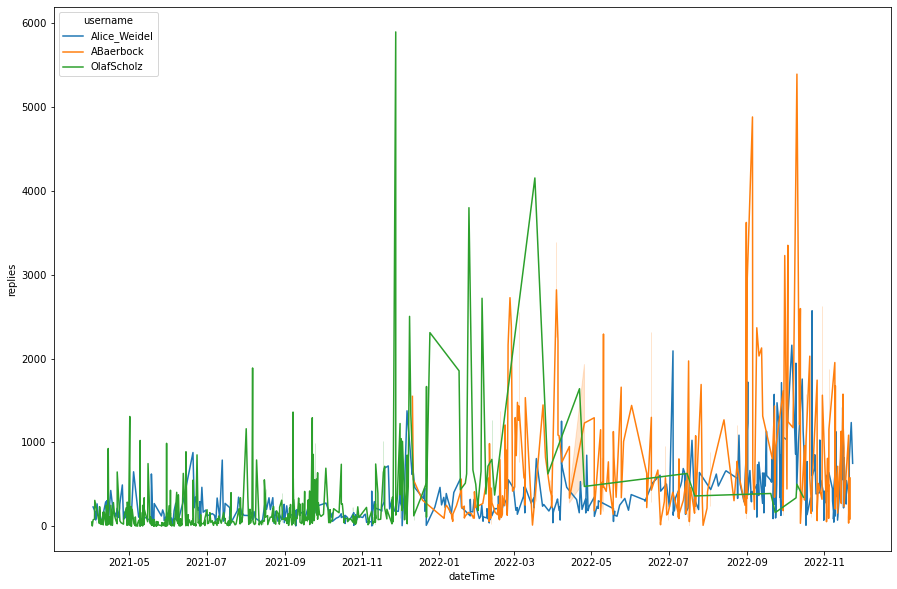

In [110]:
fig, ax = plt.subplots(figsize=(15, 10))
sea.lineplot(x="dateTime", y="replies", data=prod1_end, hue="username")